In [50]:
from bs4 import BeautifulSoup as bf
import urllib3
import numpy as np
from sklearn.metrics import r2_score
import math
%matplotlib inline 

In [ ]:
http = urllib3.PoolManager()
r = http.request('GET', 'https://www.avito.ru/rossiya/avtomobili?s_trg=4&f=')
soup = bf(r.data, 'html.parser')
print(len([price.text for price in soup.find_all('span', {"class": "price"})]))

In [ ]:
param = {
    "mark":"skoda",
    "model":"octavia",
    "body":["sedan", "limusin"],
    "engine":[0.0, 6.0],
    "year":[1960, 2019],
    
}


In [ ]:
def get_avito_url(prm):
    base = 'https://www.avito.ru/rossiya/avtomobili'
    try:
        base += "/"+ prm['mark']
    except (KeyError, TypeError):
        pass
    try:
        base += '/'+prm['model']
    except (KeyError, TypeError):
        pass
    base += '?s_trg=4&f='
    try:
        base += get_type_range_url('body', prm['body'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_range_url('year',prm['year'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_type_range_url('kpp', prm['kpp'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_range_url('engine', prm['engine'])
    except (KeyError, TypeError):
        pass
    return base
print(get_avito_url(param))

In [ ]:
body + year + kpp + engine

In [ ]:
def get_range_url(name, prms):
    base = multiple_params[name]['base']
    all_params = list(multiple_params[name])
    a1, a2=-1,-1
    for pr in all_params:
        if pr != 'base':
            if float(prms[0])<=float(pr):
                a1 = multiple_params[name][pr]
                break
    for pr in all_params:
        if pr != 'base':
            if float(prms[1])<=float(pr):
                a2 = multiple_params[name][pr]
                break
    return str(base)+'_'+str(a1)+'b'+str(a2)
get_range_url('year', [2012,2019])

In [ ]:
def get_type_range_url(name, prms):
    first, second = multiple_params[name][prms[0]], multiple_params[name][prms[1]]
    base = multiple_params[name]['base']
    return str(base)+'_'+str(first)+'-'+str(second)
print(get_type_range_url('kpp', ['mechanika', 'robot']))

In [ ]:
multiple_params = {
   'kpp':{
       'base':185,
       'mechanika':861,
       'avtomat':860,
       'robot':14754,
       'vibator':14753,
       },
    'year':{
        'base':188,
        '1960':0,
        '1970':782,
        '2012':6045,
        '2019':405242,
    },
    'body':{
        'base':187,
        'sedan':869,
        'limusin':867,
        'chechbeck':872
    },
    'engine':{
        'base':1374,
        '0.0':0,
        '0.6':15776,
        '5.5':15825,
        '6.0':15830
    },
    'mark':{
        'skoda':['octavia', 'rapid'],
        'vaz_lada':['kalina', 'granta'],
        'kia':['rio','spectra']
    },    
}

In [ ]:
np.corrcoef([[2,1, 123333],[2,1, 123333],[23,3, 2343234]], [2,1, 12])

In [ ]:
ur = 'https://www.avito.ru/rossiya/avtomobili/skoda/octavia?s_trg=4&f=187_869-867.188_0b405242.1374_0b15830'

dt = http.request('GET', ur)
soup_in = bf(dt.data, 'html.parser')

def get_data(soup):
    return [price.text for price in soup.find_all('div', {"class": "specific-params specific-params_block"})]

def get_money(soup):
    return [price.text for price in soup.find_all('span', {"class": "price"})]

def get_year(soup):
    return [price.text for price in soup.find_all('a', {"class": "item-description-title-link"})]

# shit = get_year()[:2]

# shit = get_data('https://www.avito.ru/rossiya/avtomobili/s_probegom/skoda/octavia/bityy?s_trg=4&f=187_867-869.1374_0b15830')[:2]

In [ ]:
raw_data = [preparsing(d) for d in get_data(soup_in)]
x_money = [money_prepros(d) for d in get_money(soup_in)]
x_year = [year_prepros(d) for d in get_year(soup_in)]
print(len(raw_data), len(x_money), len(x_year))

In [ ]:
def money_prepros(req):
    return req.replace(' ', '').replace('\n', '').replace('₽', '')
def year_prepros(req):
    return req.split(',')[1].replace(' ','')
def preparsing(shit):
    return [st.replace('\xa0', ' ').replace('\n', '').replace(' ', '') for st in shit.split(',')]

In [ ]:
#dispersa_anal
#bitaya 1, 0
#priceK
#milescore
#year
#dvigatel

In [ ]:
def create_train_x(money, year, request):
    train_x = []
    for rq in request:
        is_brouken = 0
        km = 0
        at,mt,amt=0,0,0
        house_power = 0
        engine_v = 0
        for i in range(len(rq)):
            if rq[i].find('Битый') != -1:
                is_brouken = 1
            if rq[i].find('км') != -1:
                km = int(rq[i].replace('км', ''))
            if rq[i].find('AT') != -1:
                at=1
            if rq[i].find('MT') != -1:
                mt=1
            if rq[i].find('AMT') != -1:
                amt=1
            if rq[i].find('л.с.') != -1:
                house_power = int(rq[i][rq[i].find('(')+1:rq[i].find('л')])
                engine_v = float(rq[i][rq[i].find('.')-1:rq[i].find('.')+2])
            if money[i] == 0 or year[i] == 0 or house_power==0 or engine_v==0 or km==0:
                continue
        train_x.append([is_brouken,money[i],km,year[i], at,mt,amt,engine_v,house_power])
    return train_x

create_train_x(x_money, x_year, raw_data)

In [ ]:
train_x = create_train_x(x_money, x_year, raw_data)
test_x = [0, 250000, 128500, 2001,1,0,0,1.8,150]

In [ ]:
coor = np.corrcoef(np.array(train_x).astype(np.float), np.array(test_x).astype(np.float))

In [ ]:
np.array(train_x).astype(np.float)

In [ ]:
np.array(test_x).astype(np.float)

In [ ]:
test_x

In [ ]:
np.array([coor[i][-1] for i in range(len(coor))]).mean()

In [ ]:
#множественный r
def get_coor_coef(train_x, train_y):
    coor = np.corrcoef(np.array(train_x).astype(np.float), np.array(train_y).astype(np.float))
    return np.array([coor[i][-1] for i in range(len(coor))]).mean()

In [ ]:
def get_r_sq(train_x, train_y):
    scores = [r2_score(np.array(test_x).astype(np.float64), np.array(train_x[i]).astype(np.float64)) for i in range(len(train_x))]
    return sum(scores)/len(scores)

In [ ]:
sq = np.array([[1, 3], [3,4]])-np.array([2, 4])
ss1 = sum(sum([it**2 for it in sq]))
print(ss1)

In [ ]:
scores = [r2_score(np.array(test_x).astype(np.float64), np.array(train_x[i]).astype(np.float64)) for i in range(len(train_x))]

In [ ]:
print(sum(scores)/len(scores))

In [ ]:
np.array(test_x).astype(np.float64).var()

In [ ]:
#norm r
def get_norm_r(r, n, p):
    return 1-(1-p)*(n-1)/(n-p-1)

In [ ]:
get_norm_r(get_coor_coef(train_x, test_x), len(train_x), len(train_x)-len(train_x[0]))

In [ ]:
std = math.sqrt(np.array(train_x).astype(np.float64).var())

In [ ]:
print(std)

In [ ]:
np_money = np.array(x_money).astype(np.float64)

In [ ]:
print(np_money.std(), np_money.mean())

In [ ]:
np_money

In [ ]:
def get_info():
    return 0.99

In [ ]:
import xlwt
from datetime import datetime

url = 'https://www.avito.ru/rossiya/avtomobili/s_probegom/skoda/octavia?s_trg=4&f=187_867-869.1374_0b15830'

style0 = xlwt.easyxf('font: name Times New Roman, color-index red, bold on',
    num_format_str='#,##0.00')
style1 = xlwt.easyxf(num_format_str='D-MMM-YY')

wb = xlwt.Workbook()
ws = wb.add_sheet('Report analogs')

reg_labes = ["Регрессионная статистика", "Множественный R", "R-квадрат", "Нормированный R-квадрат", "Стандартная ошибка", "Наблюдения", "Аналоги"]
for i in range(len(reg_labes)):
    ws.write(i, 0, reg_labes[i])
ws.write(1,1,get_info())
ws.write(2,1,get_info())
ws.write(3,1,get_info())
ws.write(4,1,get_info())
ws.write(5,1,get_info())

rows_info = get_date(tur)
mark = 'skoda'
model = 'octavia'

labes = ["#", "Mark", "Model", "Year", "Engine volume", "Mileage", "kpp", "Horse powers", 'is_bitaya', "url"]
#is_brouken,money[i],km,year[i], at,mt,amt,engine_v,house_power
for i in range(len(labes)):
    ws.write(7, i, labes[i])
for i in range(len(rows_info)):
    ws.write(8+i, 0, i+1)
    ws.write(8+i, 1, mark)
    ws.write(8+i, 2, model)
    ws.write(8+i, 3, rows_info[i][3])
    ws.write(8+i, 4, rows_info[i][7])
    ws.write(8+i, 5, rows_info[i][2])
    cur_kpp = 'MT'
    if rows_info[i][4]==1:
        rows_info[i][4] = 'AT'
    if rows_info[i][5]==1:
        rows_info[i][5] = 'MT'
    if rows_info[i][6]==1:
        rows_info[i][6] = 'AMT'
    ws.write(8+i, 6, cur_kpp)
    ws.write(8+i, 7, rows_info[i][8])
    ws.write(8+i, 8, rows_info[i][9])


wb.save('example.xls')

In [ ]:
def get_date(url):
    dt = http.request('GET', url)
    soup = bf(dt.data, 'html.parser')
    raw_data = [preparsing(d) for d in get_data(soup)]
    x_money = [money_prepros(d) for d in get_money(soup)]
    x_year = [year_prepros(d) for d in get_year(soup)]
    urls = get_url(soup)
    pre_data = create_train_x(x_money,x_year, raw_data)
    new_shit = []
    for i in range(len(urls)):
        new_shit.append(pre_data[i])
        new_shit[-1].append(urls[i])
    
    return new_shit
print(get_date(tur))

In [ ]:
def get_url(soup):
    base = 'https://www.avito.ru'
    return [base + price['href'] for price in soup.find_all('a', {"class":"item-description-title-link"}, href=True)]

In [ ]:
tur = 'https://www.avito.ru/rossiya/avtomobili/skoda/octavia?s_trg=4&f=187_869-867.188_0b405242.1374_0b15830'
dt = http.request('GET', tur)
soupt = bf(dt.data, 'html.parser')
(soupt)

In [6]:
import matplotlib.pyplot as plt

In [4]:
tsoup = get_html_from_avito(qr)
train_x = create_train_data(tsoup)
user_data = [0, qr['u_price'], qr['u_mileage'], qr['u_year'], 0,1,0,qr['u_eng'],qr['u_h_power']]

c:\users\dinmuhametov salavat\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


(array([ 4.,  0.,  4., 17., 10.,  9.,  8.,  1.,  0.,  1.]),
 array([1.220000e+02, 2.460990e+04, 4.909780e+04, 7.358570e+04,
        9.807360e+04, 1.225615e+05, 1.470494e+05, 1.715373e+05,
        1.960252e+05, 2.205131e+05, 2.450010e+05]),
 <a list of 10 Patch objects>)

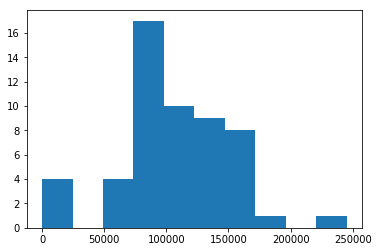

In [53]:
def hist_im(train_x, j):
    price_val = []
    for i in range(len(train_x)):
        price_val.append(train_x[i][j])
    label = ''
    if j  == 2:
        label = 'price'
    pl = plt.hist(price_val)
    pl[2][0].figure.savefig('as.png')
    return pl

hist_im(train_x, 2)

(array([ 6.,  0.,  0., 21., 12.,  0.,  2.,  0., 11.,  2.]),
 array([ 80.,  87.,  94., 101., 108., 115., 122., 129., 136., 143., 150.]),
 <a list of 10 Patch objects>)

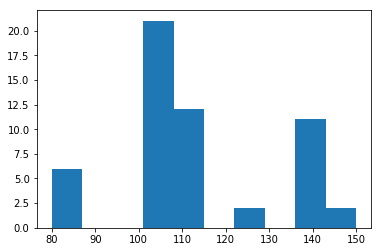

In [28]:
def engine_vol_hist(train_x):
    price_val = []
    for i in range(len(train_x)):
        price_val.append(train_x[i][8])
    return plt.hist(price_val)
engine_vol_pie(train_x)

In [3]:
from bs4 import BeautifulSoup as bf
import urllib3
import numpy as np
from sklearn.metrics import r2_score
import xlwt
from datetime import datetime
import os

qr = {
    'mark':'skoda',
    'model':'octavia', 
    'year':['2011','2018'],
    'engine':['0.0', '1.6'], 
    'millage':[25,2500],
    'kpp':'mechanika',
    'u_price':'250000',
    'u_mileage':'250000',
    'u_year':'2012',
    'u_eng':'1.6',
    'u_h_power':100,
    'email':'perfog@mail.ru'
}

tsoup = get_html_from_avito(qr)
train_x = create_train_data(tsoup)
user_data = [0, qr['u_price'], qr['u_mileage'], qr['u_year'], 0,1,0,qr['u_eng'],qr['u_h_power']]


def sent_email(email):
    msg = EmailMessage('Report','your_report', 'salavatarus@gmail.com',[email])
    msg.attach_file('media/report.xls')
    msg.send()


def create_xls(qr,data,soup):

    style0 = xlwt.easyxf('font: name Times New Roman, color-index red, bold on',
        num_format_str='#,##0.00')
    style1 = xlwt.easyxf(num_format_str='D-MMM-YY')

    wb = xlwt.Workbook()
    ws = wb.add_sheet('Report analogs')

    reg_labes = ["Регрессионная статистика", "Множественный R", "R-квадрат", "Нормированный R-квадрат", "Стандартная ошибка", "Наблюдения", "Аналоги"]
    for i in range(len(reg_labes)):
        ws.write(i, 0, reg_labes[i])
    ws.write(1,1,data['multi_r'])
    ws.write(2,1,data['r_sqr'])
    ws.write(3,1,data['norm_r'])
    ws.write(4,1,data['std'])
    ws.write(5,1,data['n'])

    rows_info = get_date(soup)
    mark = qr['mark']
    model = qr['model']

    labes = ["#", "Mark", "Model", "Year", "Engine volume", "Mileage", "kpp", "Horse powers", 'is_bitaya', "url"]
    #is_brouken,money[i],km,year[i], at,mt,amt,engine_v,house_power
    for i in range(len(labes)):
        ws.write(7, i, labes[i])
    for i in range(len(rows_info)):
        ws.write(8+i, 0, i+1)
        ws.write(8+i, 1, mark)
        ws.write(8+i, 2, model)
        ws.write(8+i, 3, rows_info[i][3])
        ws.write(8+i, 4, rows_info[i][7])
        ws.write(8+i, 5, rows_info[i][2])
        cur_kpp = 'MT'
        if rows_info[i][4]==1:
            rows_info[i][4] = 'AT'
        if rows_info[i][5]==1:
            rows_info[i][5] = 'MT'
        if rows_info[i][6]==1:
            rows_info[i][6] = 'AMT'
        ws.write(8+i, 6, cur_kpp)
        ws.write(8+i, 7, rows_info[i][8])
        ws.write(8+i, 8, rows_info[i][9])
    file_location = './media/report.xls'
    wb.save(file_location)
    print(os.path.join(settings.MEDIA_ROOT, 'report.xls'))
    return os.path.join(settings.MEDIA_ROOT, 'report.xls')

def get_date(soup):
    raw_data = [preparsing(d) for d in get_data(soup)]
    x_money = [money_prepros(d) for d in get_money(soup)]
    x_year = [year_prepros(d) for d in get_year(soup)]
    urls = get_url(soup)
    pre_data = create_train_x(x_money,x_year, raw_data)
    new_shit = []
    for i in range(len(urls)):
        new_shit.append(pre_data[i])
        new_shit[-1].append(urls[i])

    return new_shit

def create_train_data(soup_in):
    raw_data = [preparsing(d) for d in get_data(soup_in)]
    x_money = [money_prepros(d) for d in get_money(soup_in)]
    x_year = [year_prepros(d) for d in get_year(soup_in)]
    train_x = create_train_x(x_money, x_year, raw_data)
    return train_x

def get_market_std(soup):
    money = [money_prepros(d) for d in get_money(soup)]
    train_x = np.array(money).astype(np.float64)
    return train_x.std()

def get_market_mean(soup):
    money = [money_prepros(d) for d in get_money(soup)]
    train_x = np.array(money).astype(np.float64)
    return train_x.mean()

def get_market_n(soup):
    money = [money_prepros(d) for d in get_money(soup)]
    train_x = np.array(money).astype(np.float64)
    return len(train_x)

def get_html_from_avito(params):
    http = urllib3.PoolManager()
    answer = ''

    avito_url = get_avito_url(params)
    r = http.request('GET', avito_url)
    soup = bf(r.data, 'html.parser')
    return soup

def get_avito_url(prm):
    base = 'https://www.avito.ru/rossiya/avtomobili'
    try:
        base += "/"+ prm['mark']
    except (KeyError, TypeError):
        pass
    try:
        base += '/'+prm['model']
    except (KeyError, TypeError):
        pass
    base += '?s_trg=4&f='
    try:
        base += get_type_range_url('body', prm['body'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_range_url('year',prm['year'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_type_range_url('kpp', prm['kpp'])
    except (KeyError, TypeError):
        pass
    try:
        base += '.'+get_range_url('engine', prm['engine'])
    except (KeyError, TypeError):
        pass
    return base

def get_range_url(name, prms):
    base = multiple_params[name]['base']
    all_params = list(multiple_params[name])
    a1, a2=-1,-1
    for pr in all_params:
        if pr != 'base':
            if float(prms[0])<=float(pr):
                a1 = multiple_params[name][pr]
                break
    for pr in all_params:
        if pr != 'base':
            if float(prms[1])<=float(pr):
                a2 = multiple_params[name][pr]
                break
    return str(base)+'_'+str(a1)+'b'+str(a2)

def get_type_range_url(name, prms):
    first, second = multiple_params[name][prms[0]], multiple_params[name][prms[1]]
    base = multiple_params[name]['base']
    return str(base)+'_'+str(first)+'-'+str(second)

def create_reg_anal():
    pass

def get_data(soup):
    return [price.text for price in soup.find_all('div', {"class": "specific-params specific-params_block"})]

def get_money(soup):
    return [price.text for price in soup.find_all('span', {"class": "price"})]

def get_year(soup):
    return [price.text for price in soup.find_all('a', {"class": "item-description-title-link"})]

def get_url(soup):
    base = 'https://www.avito.ru'
    return [base + price['href'] for price in soup.find_all('a', {"class":"item-description-title-link"}, href=True)]

def money_prepros(req):
    return req.replace(' ', '').replace('\n', '').replace('₽', '')
def year_prepros(req):
    return req.split(',')[1].replace(' ','')
def preparsing(shit):
    return [st.replace('\xa0', ' ').replace('\n', '').replace(' ', '') for st in shit.split(',')]

def create_train_x(x_money, x_year, request):
    train_x = []
    for rq in request:
        is_brouken = 0
        km = 0
        at,mt,amt=0,0,0
        house_power = 0
        engine_v = 0
        for i in range(len(rq)):
            if rq[i].find('Битый') != -1:
                is_brouken = 1
            if rq[i].find('км') != -1:
                km = int(rq[i].replace('км', ''))
            if rq[i].find('AT') != -1:
                at=1
            if rq[i].find('MT') != -1:
                mt=1
            if rq[i].find('AMT') != -1:
                amt=1
            if rq[i].find('л.с.') != -1:
                house_power = int(rq[i][rq[i].find('(')+1:rq[i].find('л')])
                engine_v = float(rq[i][rq[i].find('.')-1:rq[i].find('.')+2])
            if x_money[i] == 0 or x_year[i] == 0 or house_power==0 or engine_v==0 or km==0:
                continue
        train_x.append([is_brouken,x_money[i],km,x_year[i], at,mt,amt,engine_v,house_power])
    return train_x

def get_coor_coef(train_x, train_y):
    coor = np.corrcoef(np.array(train_x).astype(np.float), np.array(train_y).astype(np.float))
    return np.array([coor[i][-1] for i in range(len(coor))]).mean()

def get_r_sq(train_x, train_y):
    scores = [r2_score(np.array(train_y).astype(np.float64), np.array(train_x[i]).astype(np.float64)) for i in range(len(train_x))]
    return sum(scores)/len(scores)

def get_norm_r(train_x ,user_data):
    r = get_coor_coef(train_x, user_data)
    n = len(train_x)
    p = len(train_x)-len(train_x[0])
    return 1-(1-p)*(n-1)/(n-p-1)




multiple_params = {
   'kpp':{
       'base':185,
       'mechanika':861,
       'avtomat':860,
       'robot':14754,
       'vibator':14753,
       },
    'year':{
        'base':188,
        '1960':0,
        '1970':782,
        '1999':892,
        '2004':897,
        '2007':900,
        '2012':6045,
        '2014':11017,
        '2016':16381,
        '2018':20303,
        '2019':405242,
    },
    'body':{
        'base':187,
        'sedan':869,
        'limusin':867,
        'chechbeck':872
    },
    'engine':{
        'base':1374,
        '0.0':0,
        '0.6':15776,
        '0.7':15777,
        '0.8':15778,
        '1.0':15780,
        '1.2':15782,
        '1.4':15784,
        '1.6':15786,
        '2.2':15792,
        '5.5':15825,
        '6.0':15830
    },
    'mark':{
        'skoda':['octavia', 'rapid'],
        'vaz_lada':['kalina', 'granta', 'xray','2103','2104','2105', "largus", 'priora', 'vesta'],
        'kia':['rio','spectra']
    },
}


c:\users\dinmuhametov salavat\appdata\local\programs\python\python36\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
